In [3]:
import os

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import torch

import warnings

warnings.filterwarnings('ignore')

In [4]:
# train в конце сплитится
df = pd.read_csv('./train.csv')
weather = pd.read_csv('./weather_data_nyc_centralpark_2016.csv')
# weather https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016
# weather = pd.read_csv('./weather.csv')

# расстояние, достопримечательности

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


<function seaborn.relational.scatterplot(*, x=None, y=None, hue=None, style=None, size=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, x_bins=None, y_bins=None, units=None, estimator=None, ci=95, n_boot=1000, alpha=None, x_jitter=None, y_jitter=None, legend='auto', ax=None, **kwargs)>

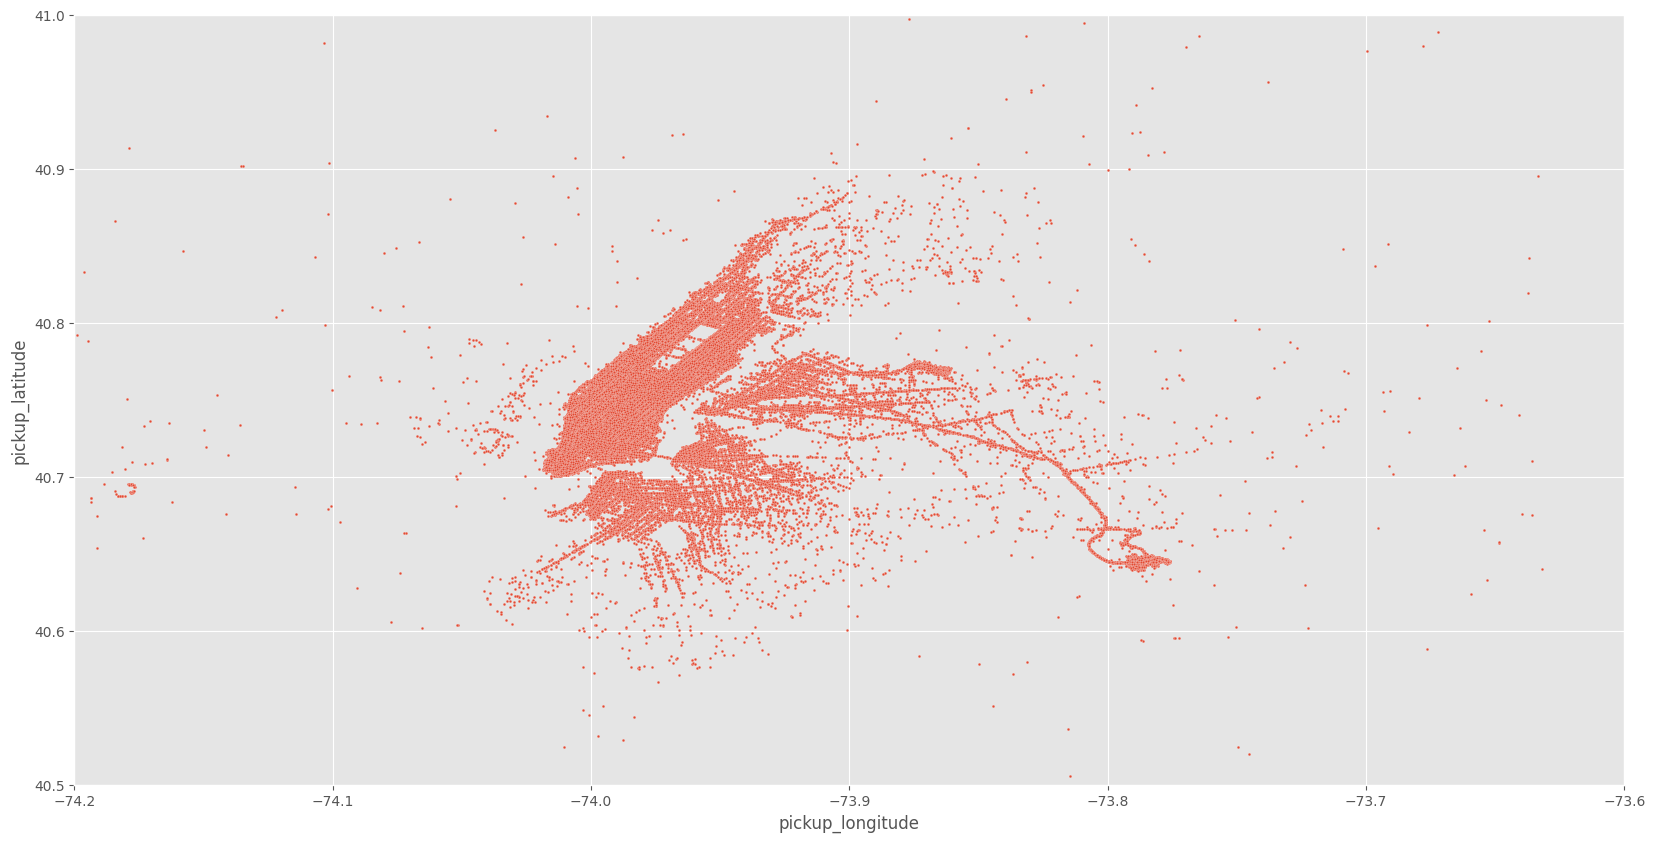

In [125]:
# анализ маршрутов
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.scatterplot(df['pickup_longitude'], df['pickup_latitude'], s=4, ax=ax)
ax.set_xlim([-74.2, -73.6])
ax.set_ylim([40.5, 41.0])

sns.scatterplot

In [6]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [7]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,5237.43172
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,1075.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,3526282.00000


In [ ]:
# выбросы по координатам (Антарктида ?!), по количеству пассажиров (есть нуль)
# trip_duration - целевая переменная, одна секунда ?1

In [9]:
# отсекаем точки по google-карте
df = df[df.pickup_longitude.between(-75, -71) & df.dropoff_longitude.between(-75, 71)]

In [10]:
from math import radians, cos, sin, asin, sqrt

# вычисление расстояния в километрах между двумя точками на Земле
def haversine(data):
    lon1 = data['pickup_longitude']
    lat1 = data['pickup_latitude']
    lon2 = data['dropoff_longitude']
    lat2 = data['dropoff_latitude']
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    r = 6371
    return c * r

In [13]:
pip install pandas jupyter pandarallel requests tqdm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 110.5/110.5 kB 711.2 kB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16696 sha256=761a7be20cbde8f7443763e4fcd802b31f827d4d5e495a831d951dbc6572420b
  Stored in directory: c:\users\grish\appdata\local\pip\cache\wheels\41\01\29\deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel
Note: you may need to restart the kernel to use updated packages.


In [15]:
# параллельные вычисления
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [11]:
df['distance_geo'] = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].parallel_apply(haversine, axis=1)

In [16]:
df['distance_geo']

0         1.49852
1         1.80551
2         6.38510
3         1.48550
4         1.18859
            ...  
1458639   1.22508
1458640   6.04984
1458641   7.82461
1458642   1.09256
1458643   1.13404
Name: distance_geo, Length: 1458613, dtype: float64

In [17]:
weather.describe(include='object')

,date,precipitation,snow fall,snow depth
count,366,366,366,366
unique,366,63,11,10
top,1-1-2016,0,0,0
freq,1,116,179,346


In [18]:
weather.precipitation.unique() #T? T = не нашлось видимых значений, приводим к нулю, 

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [20]:
weather.loc[weather['precipitation'] == 'T', 'precipitation'] = '0.00'
weather['precipitation'] = weather['precipitation'].astype(float)

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype(float)

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype(float)

In [21]:
df['pickup_datetime']

0          2016-03-14 17:24:55
1          2016-06-12 00:43:35
2          2016-01-19 11:35:24
3          2016-04-06 19:32:31
4          2016-03-26 13:30:55
                  ...         
1458639    2016-04-08 13:31:04
1458640    2016-01-10 07:35:15
1458641    2016-04-22 06:57:41
1458642    2016-01-05 15:56:26
1458643    2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458613, dtype: object

In [24]:
df['date'] = df.pickup_datetime.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
weather['date'] = weather.date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

In [26]:
df['date']

0         2016-03-14
1         2016-06-12
2         2016-01-19
3         2016-04-06
4         2016-03-26
             ...    
1458639   2016-04-08
1458640   2016-01-10
1458641   2016-04-22
1458642   2016-01-05
1458643   2016-04-05
Name: date, Length: 1458613, dtype: datetime64[ns]

In [27]:
weather['date']

0     2016-01-01
1     2016-01-02
2     2016-01-03
3     2016-01-04
4     2016-01-05
         ...    
361   2016-12-27
362   2016-12-28
363   2016-12-29
364   2016-12-30
365   2016-12-31
Name: date, Length: 366, dtype: datetime64[ns]

In [28]:
df = pd.merge(df, weather, how='left', on='date')

In [29]:
df.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
distance_geo           0
date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

In [31]:
weather[:5]

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.00000,0.00000,0.00000,0.00000
1,2016-01-02,40,32,36.00000,0.00000,0.00000,0.00000
2,2016-01-03,45,35,40.00000,0.00000,0.00000,0.00000
3,2016-01-04,36,14,25.00000,0.00000,0.00000,0.00000
4,2016-01-05,29,11,20.00000,0.00000,0.00000,0.00000


In [30]:
df[:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,1.49852,2016-03-14,51,40,45.50000,0.29000,0.00000,0.00000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,1.80551,2016-06-12,83,62,72.50000,0.00000,0.00000,0.00000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,2124,6.38510,2016-01-19,28,16,22.00000,0.00000,0.00000,0.00000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,429,1.48550,2016-04-06,48,30,39.00000,0.00000,0.00000,0.00000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,435,1.18859,2016-03-26,55,38,46.50000,0.00000,0.00000,0.00000


In [23]:
# преобразуем дату в новые признаки, которые будет удобно исследовать
df['pickup_datetime']

0          2016-03-14 17:24:55
1          2016-06-12 00:43:35
2          2016-01-19 11:35:24
3          2016-04-06 19:32:31
4          2016-03-26 13:30:55
                  ...         
1458639    2016-04-08 13:31:04
1458640    2016-01-10 07:35:15
1458641    2016-04-22 06:57:41
1458642    2016-01-05 15:56:26
1458643    2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458613, dtype: object

In [39]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['pickup_month'] = df['pickup_datetime'].apply(lambda x: x.month)
df['pickup_day'] = df['pickup_datetime'].apply(lambda x: x.day)
df['pickup_dayofweek'] = df['pickup_datetime'].apply(lambda x: x.dayofweek)
df['pickup_hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
df['pickup_minute'] = df['pickup_datetime'].apply(lambda x: x.minute)
df['pickup_weekends'] = df['pickup_dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)

# store_and_fwd_flag -> boolean
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

In [38]:
df['pickup_dayofweek'].unique()

array([0, 6, 1, 2, 5, 4, 3], dtype=int64)

In [36]:
df.reset_index(drop=True, inplace=True) #сброс индексов

In [42]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

df['pickup_holiday'] = df['date'].isin(holidays)
df['pickup_holiday'] = df['pickup_holiday'].map(lambda x: 1 if x == True else 0)

df['pickup_near_holiday'] = df['date'].isin(holidays + timedelta(days=1)) | df['date'].isin(holidays - timedelta(days=1))
df['pickup_near_holiday'] = df['pickup_near_holiday'].map(lambda x: 1 if x == True else 0)

In [43]:
holidays

DatetimeIndex(['1970-01-01', '1970-02-16', '1970-05-25', '1970-07-03',
               '1970-09-07', '1970-10-12', '1970-11-11', '1970-11-26',
               '1970-12-25', '1971-01-01',
               ...
               '2200-01-20', '2200-02-17', '2200-05-26', '2200-06-19',
               '2200-07-04', '2200-09-01', '2200-10-13', '2200-11-11',
               '2200-11-27', '2200-12-25'],
              dtype='datetime64[ns]', length=2474, freq=None)

In [44]:
# посмотрим на распределение времени
df['trip_duration'].describe()

count   1458613.00000
mean        959.46331
std        5237.43041
min           1.00000
25%         397.00000
50%         662.00000
75%        1075.00000
max     3526282.00000
Name: trip_duration, dtype: float64

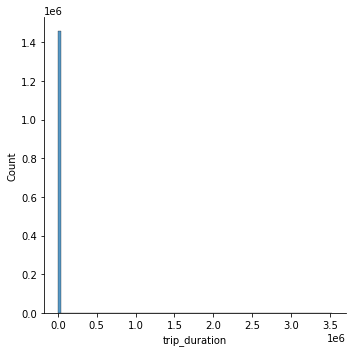

In [44]:
sns.displot(df.trip_duration, bins=100)

In [45]:
# прологарифмируем целевую переменную
df = df.assign(log_trip_duration = np.log(df.trip_duration + 1))

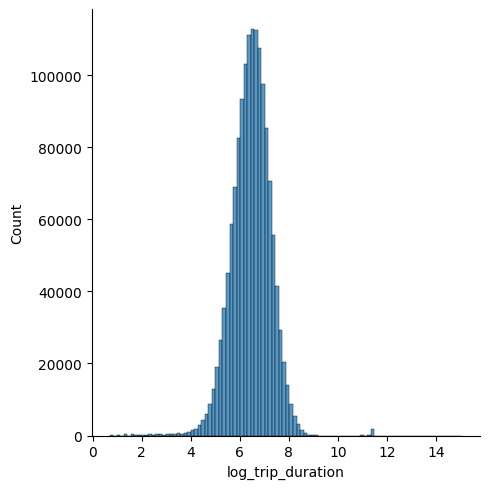

In [46]:
sns.displot(df.log_trip_duration, bins=100)

In [48]:
pd.set_option('display.max_columns', None)

In [49]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,pickup_month,pickup_day,pickup_dayofweek,pickup_hour,pickup_minute,pickup_weekends,pickup_holiday,pickup_near_holiday,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,0,455,1.49852,2016-03-14,51,40,45.50000,0.29000,0.00000,0.00000,3,14,0,17,24,0,0,0,6.12249
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,0,663,1.80551,2016-06-12,83,62,72.50000,0.00000,0.00000,0.00000,6,12,6,0,43,1,0,0,6.49828
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,0,2124,6.38510,2016-01-19,28,16,22.00000,0.00000,0.00000,0.00000,1,19,1,11,35,0,0,1,7.66153
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,0,429,1.48550,2016-04-06,48,30,39.00000,0.00000,0.00000,0.00000,4,6,2,19,32,0,0,0,6.06379
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,0,435,1.18859,2016-03-26,55,38,46.50000,0.00000,0.00000,0.00000,3,26,5,13,30,1,0,0,6.07764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458608,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98220,40.74552,-73.99491,40.74017,0,778,1.22508,2016-04-08,50,40,45.00000,0.01000,0.00000,0.00000,4,8,4,13,31,0,0,0,6.65801
1458609,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00095,40.74738,-73.97018,40.79655,0,655,6.04984,2016-01-10,59,40,49.50000,1.80000,0.00000,0.00000,1,10,6,7,35,1,0,0,6.48616
1458610,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.95913,40.76880,-74.00443,40.70737,0,764,7.82461,2016-04-22,79,62,70.50000,0.00000,0.00000,0.00000,4,22,4,6,57,0,0,0,6.63988
1458611,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98208,40.74906,-73.97463,40.75711,0,373,1.09256,2016-01-05,29,11,20.00000,0.00000,0.00000,0.00000,1,5,1,15,56,0,0,0,5.92426


In [50]:
# исседовательский компонент, к удалению
df['trip_duration_hour'] = df['trip_duration'] / 3600
df['speed_km_h'] = df['distance_geo'] / df['trip_duration_hour']

In [51]:
df['speed_km_h'].describe() #явные выбросы

count   1458613.00000
mean         14.41106
std          13.67942
min           0.00000
25%           9.12139
50%          12.79199
75%          17.84469
max        9274.83673
Name: speed_km_h, dtype: float64

In [52]:
df['passenger_count'].unique() #достаточно шести пассажиров

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [86]:
df = df[~df.passenger_count.isin([0, 7, 9, 8])]
df = df[df['speed_km_h'] != 0]

In [54]:
num_cols = ['trip_duration_hour', 'speed_km_h', 'distance_geo']

num_features = df[num_cols]
num_features = num_features.stack().reset_index()

In [56]:
num_features = num_features.rename(columns={'level_1': 'Features', 0: 'Value'})

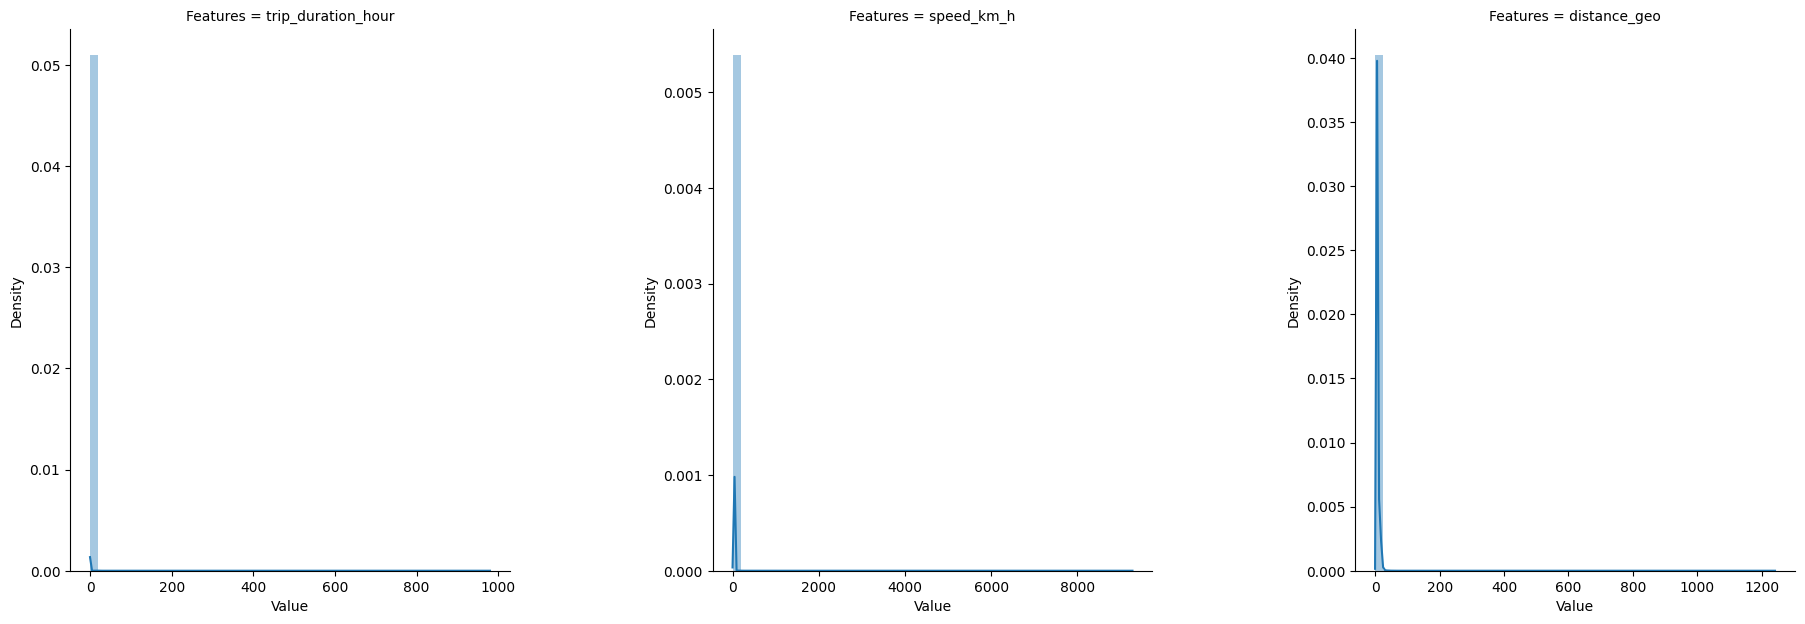

In [59]:
ax = sns.FacetGrid(data=num_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

In [60]:
for i in num_cols:
    df['log_' + i] = np.log(df[i]+1)

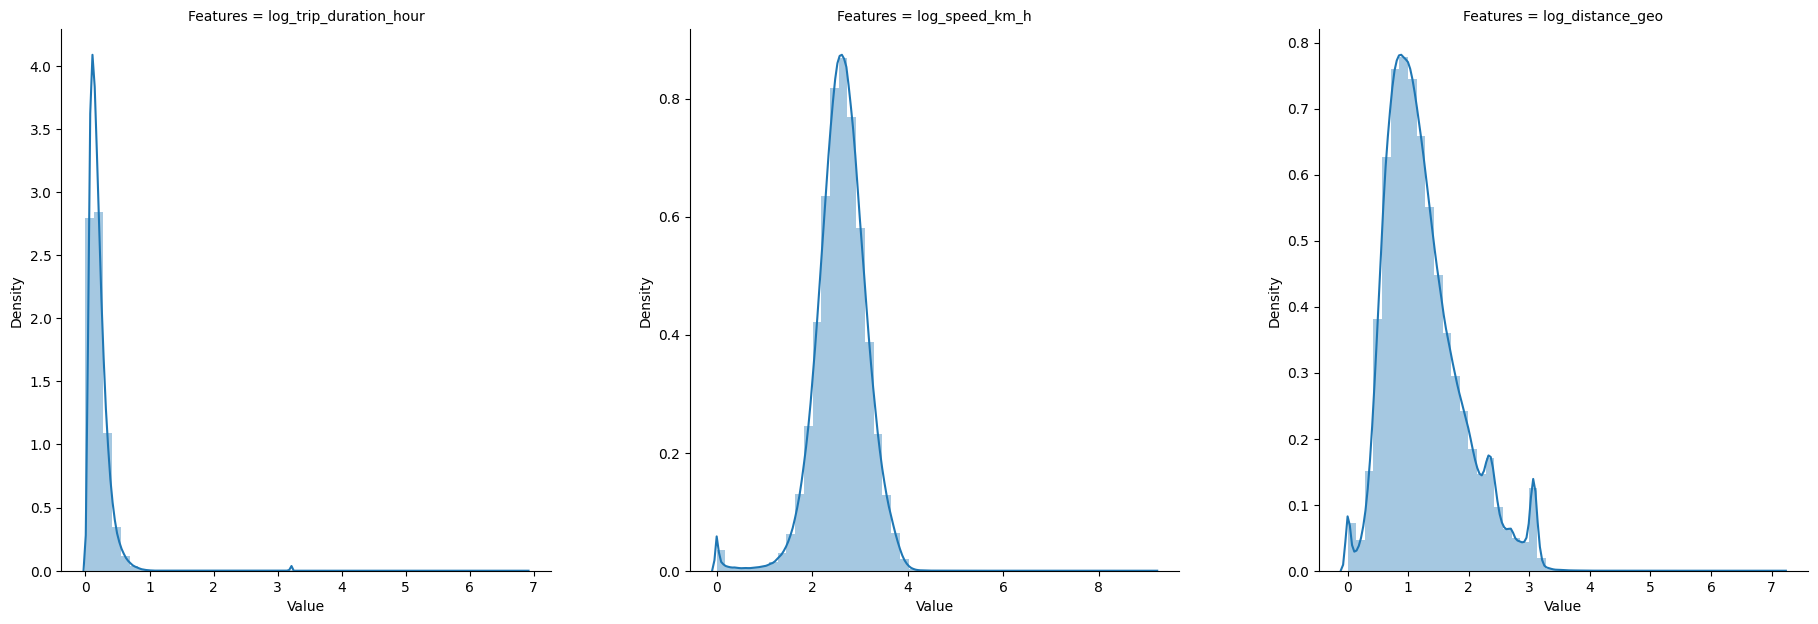

In [61]:
num_cols = ['log_trip_duration_hour', 'log_speed_km_h', 'log_distance_geo']

num_features = df[num_cols]
num_features = num_features.stack().reset_index().rename(columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=num_features, col='Features', col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

In [64]:
norm_hours = df.groupby(['pickup_weekends'])['pickup_hour'].value_counts()

In [65]:
norm_hours

pickup_weekends  pickup_hour
0                19             67212
                 18             66576
                 21             64073
                 20             63705
                 22             60229
                 8              57240
                 17             54517
                 9              53427
                 14             52828
                 15             50748
                 23             50252
                 12             49998
                 13             49490
                 7              49029
                 11             48096
                 10             47348
                 16             44496
                 0              29210
                 6              28564
                 1              17722
                 2              11150
                 5              11043
                 3               7992
                 4               7443
1                0              24038
                 18  

In [66]:
norm_hours = df.groupby(['pickup_weekends'])['pickup_hour'].value_counts(normalize = True)

In [67]:
norm_hours

pickup_weekends  pickup_hour
0                19            0.06448
                 18            0.06387
                 21            0.06147
                 20            0.06111
                 22            0.05778
                 8             0.05491
                 17            0.05230
                 9             0.05125
                 14            0.05068
                 15            0.04868
                 23            0.04821
                 12            0.04796
                 13            0.04748
                 7             0.04704
                 11            0.04614
                 10            0.04542
                 16            0.04269
                 0             0.02802
                 6             0.02740
                 1             0.01700
                 2             0.01070
                 5             0.01059
                 3             0.00767
                 4             0.00714
1                0             0.05

In [69]:
norm_hours = df.groupby(['pickup_weekends'])['pickup_hour'].value_counts(normalize=True).rename('percentage').mul(100)

pickup_weekends  pickup_hour
0                19            6.44789
                 18            6.38687
                 21            6.14675
                 20            6.11145
                 22            5.77798
                 8             5.49124
                 17            5.23001
                 9             5.12544
                 14            5.06798
                 15            4.86844
                 23            4.82085
                 12            4.79649
                 13            4.74775
                 7             4.70353
                 11            4.61402
                 10            4.54226
                 16            4.26866
                 0             2.80222
                 6             2.74025
                 1             1.70013
                 2             1.06966
                 5             1.05939
                 3             0.76670
                 4             0.71403
1                0             5.77

In [71]:
norm_hours = norm_hours.reset_index()

In [72]:
norm_hours

,pickup_weekends,pickup_hour,percentage
0,0,19,6.44789
1,0,18,6.38687
2,0,21,6.14675
3,0,20,6.11145
4,0,22,5.77798
5,0,8,5.49124
6,0,17,5.23001
7,0,9,5.12544
8,0,14,5.06798
9,0,15,4.86844


In [73]:
norm_hours = norm_hours.sort_values('pickup_hour')

In [74]:
norm_hours

,pickup_weekends,pickup_hour,percentage
24,1,0,5.77524
17,0,0,2.80222
32,1,1,5.00883
19,0,1,1.70013
40,1,2,4.04156
20,0,2,1.06966
42,1,3,3.10001
22,0,3,0.76670
23,0,4,0.71403
44,1,4,2.00589


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

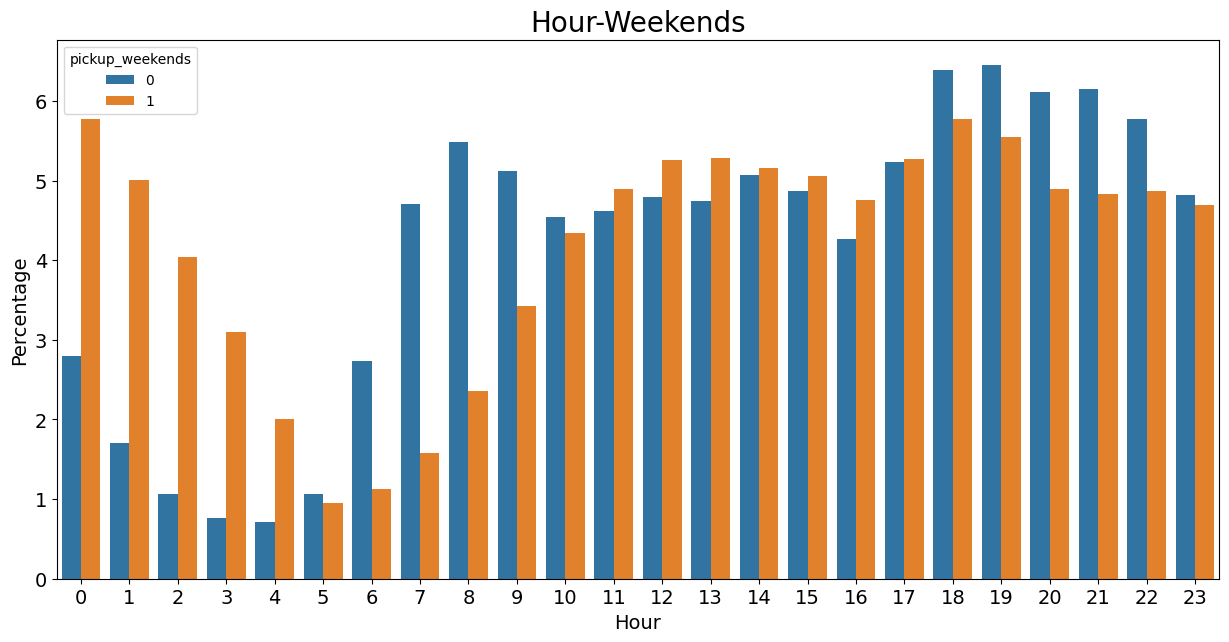

In [75]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='pickup_hour', y='percentage', hue='pickup_weekends', data=norm_hours)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

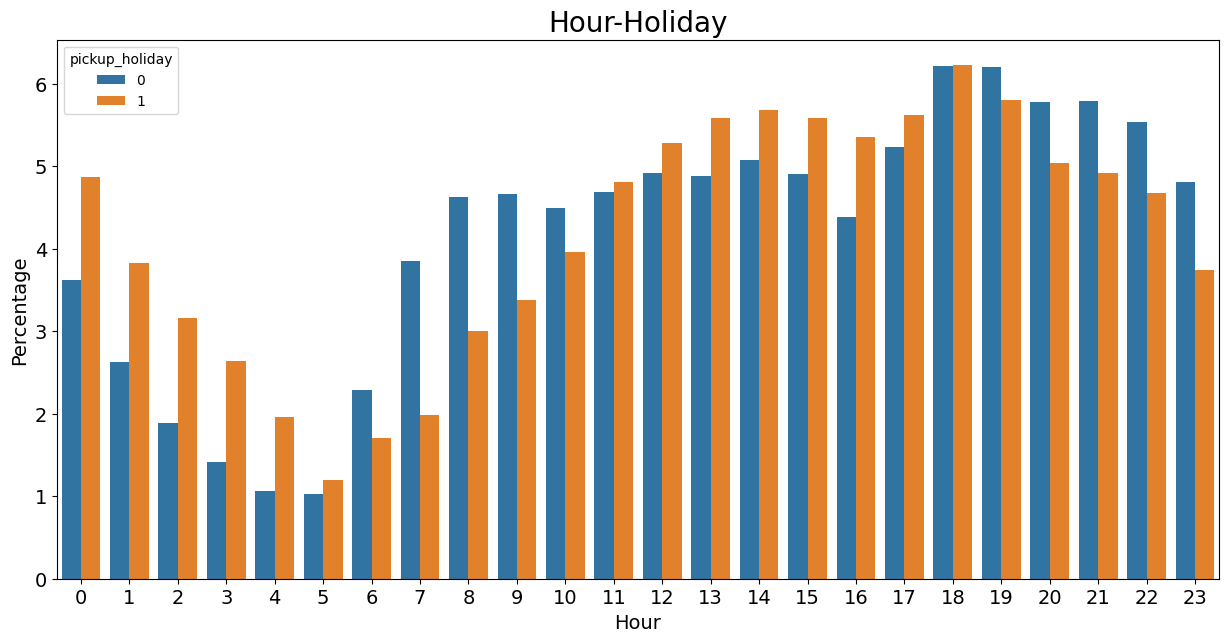

In [76]:
norm_hours = df.groupby(['pickup_holiday'])['pickup_hour'].value_counts(normalize=True).rename('percentage').mul(100)
norm_hours = norm_hours.reset_index()
norm_hours = norm_hours.sort_values('pickup_hour')

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='pickup_hour', y='percentage', hue='pickup_holiday', data=norm_hours)

plt.title('Hour-Holiday', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

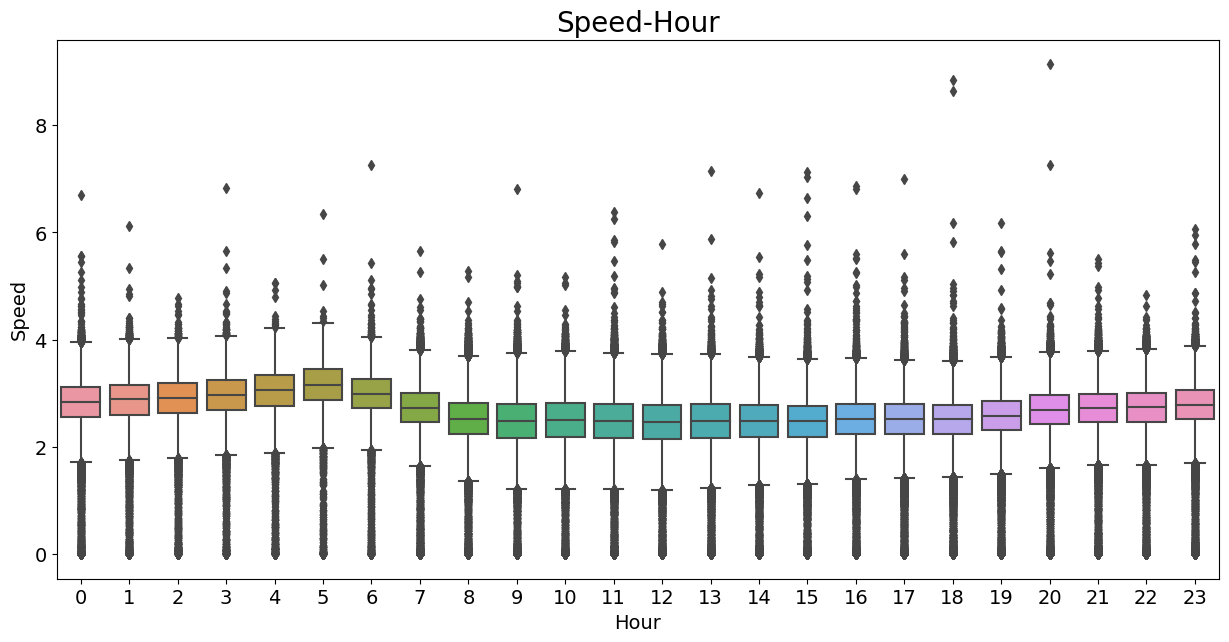

In [78]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_speed_km_h', data=df)

plt.title('Speed-Hour', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

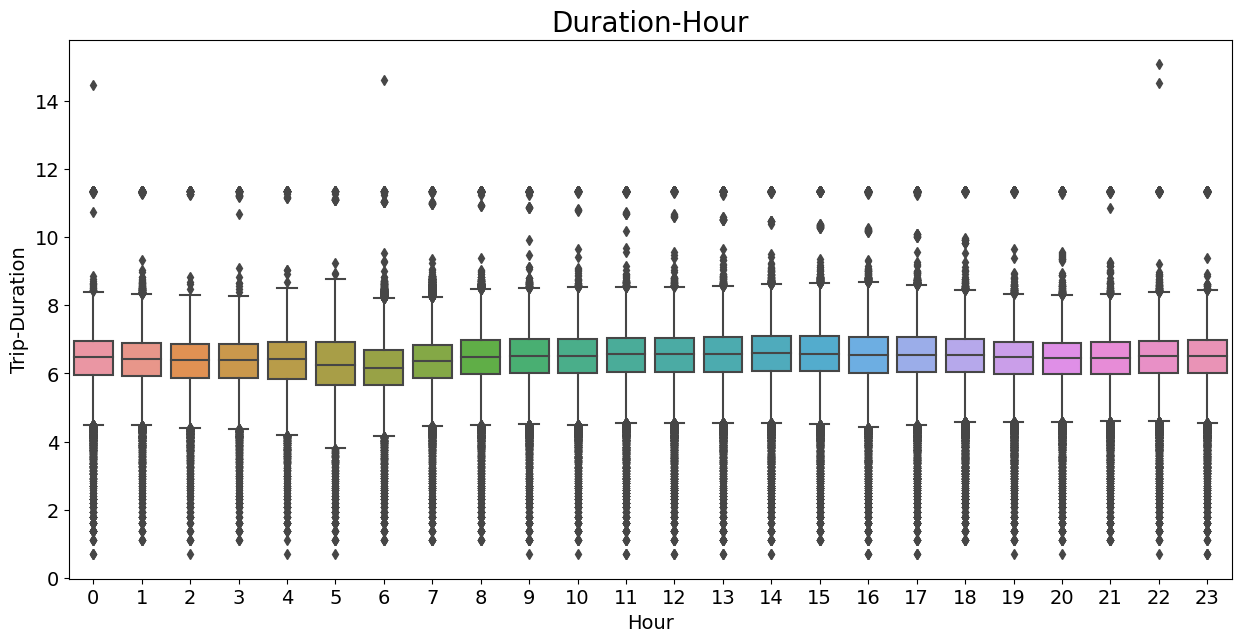

In [80]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_trip_duration', data=df)

plt.title('Duration-Hour', fontsize=20)
plt.ylabel('Trip-Duration', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

<AxesSubplot:>

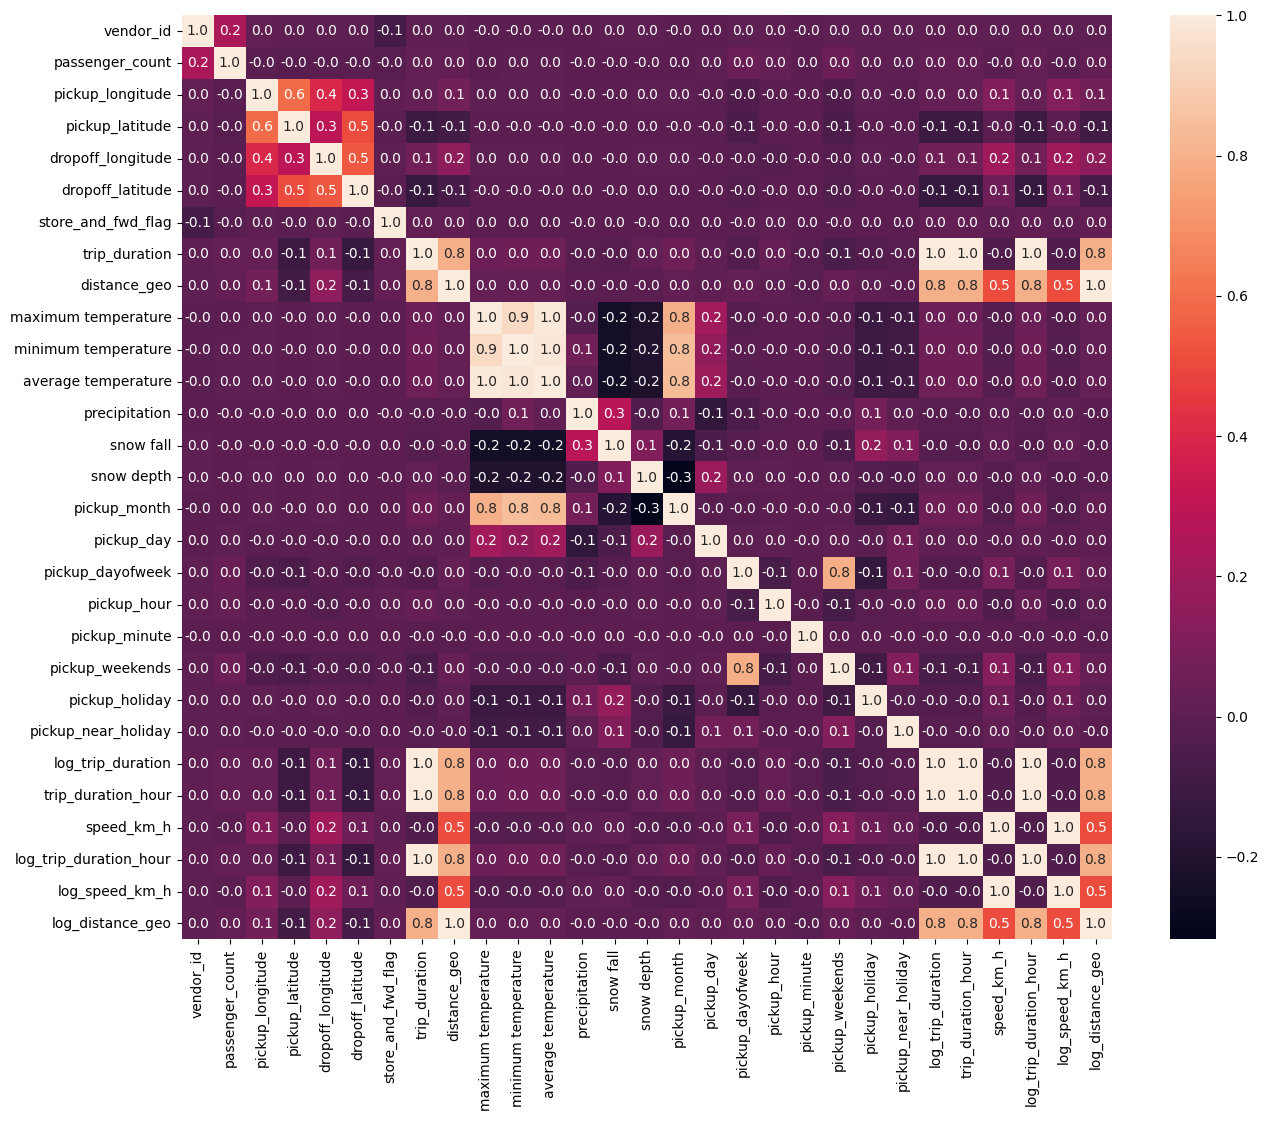

In [81]:
plt.figure(figsize=(15, 12))

sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1f')

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

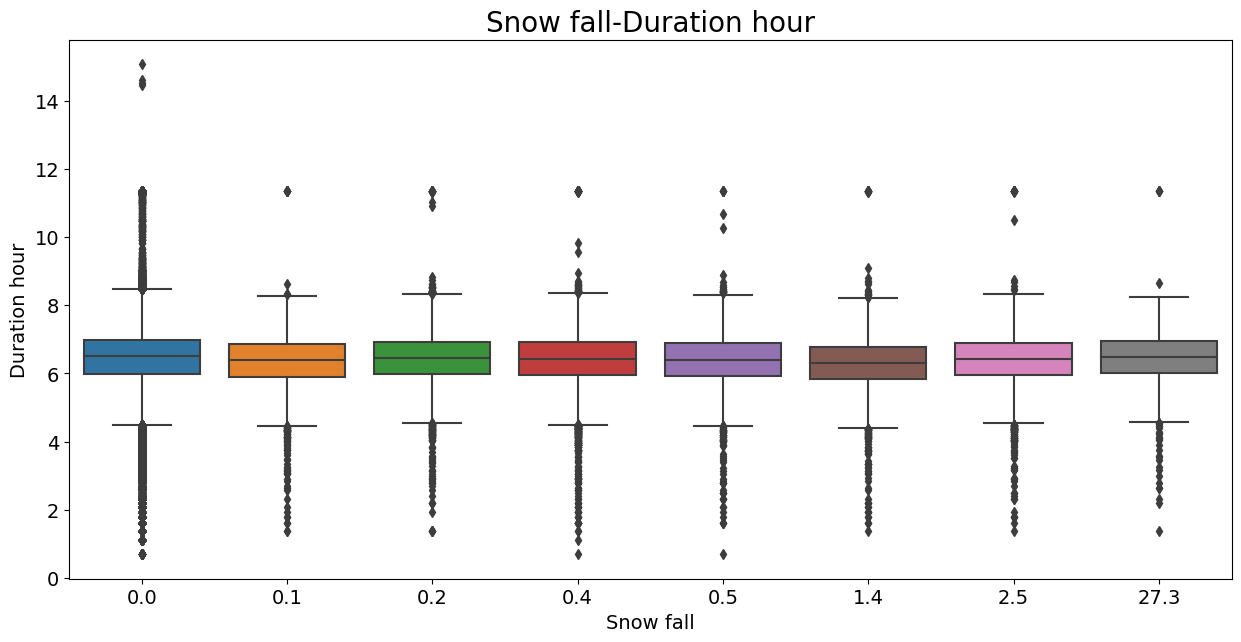

In [82]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_trip_duration', data=df)

plt.title('Snow fall-Duration hour', fontsize=20)
plt.ylabel('Duration hour', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [83]:
import lightgbm as lg

In [85]:
import optuna

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

In [87]:
drop_cols_train = [
    'id', 'pickup_datetime', 'dropoff_datetime',
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'distance_geo',
    'date', 
    'trip_duration', 'log_trip_duration', 'trip_duration_hour', 'log_trip_duration_hour',
    'speed_km_h', 'log_speed_km_h'
]

In [88]:
X = df.drop(columns=drop_cols_train, axis=1)
y = df['log_trip_duration']

In [90]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [93]:
# метрика наиболее устойчива к выбросам
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [97]:
import optuna

In [99]:
from optuna.integration import LightGBMPruningCallback

In [107]:
# целевая функция
def objective(trial, X, y):
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200, step=50)
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2')
        model = lg.LGBMRegressor(objective='regression', **param_grid)
        
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmsle', early_stopping_rounds=100, callbacks=[pruning_callback], verbose=-1)
        preds = model.predict(X_test)
        cv_predicts[idx] = rmsle(y_test, preds)
        
    return np.mean(cv_predicts)

In [108]:
study = optuna.create_study(direction='minimize', study_name='LGB')
func = lambda trial: objective(trial, X_train, y_train)

study.optimize(func, n_trials=2, show_progress_bar=True)

[I 2023-03-12 12:47:19,921] A new study created in memory with name: LGB


  0%|          | 0/2 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.202825
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.200653
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.201351
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.203413
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.200831
[I 2023-03-12 12:51:16,894] Trial 0 finished with value: 0.0636432562592372 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0682074849583746, 'num_leaves': 220, 'max_depth': 3, 'min_child_samples': 155}. Best is trial 0 with value: 0.0636432562592372.
Training until validation scores don't i

In [109]:
print(f'\tBest value (rmsle): {study.best_value:.5f}')
print(f'\tBest params:')

for key, value in study.best_params.items():
    print(f'\t\t{key}: {value}')

	Best value (rmsle): 0.06355
	Best params:
		n_estimators: 1000
		learning_rate: 0.12192915848364809
		num_leaves: 220
		max_depth: 7
		min_child_samples: 105


In [110]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.12192915848364809,
 'num_leaves': 220,
 'max_depth': 7,
 'min_child_samples': 105}

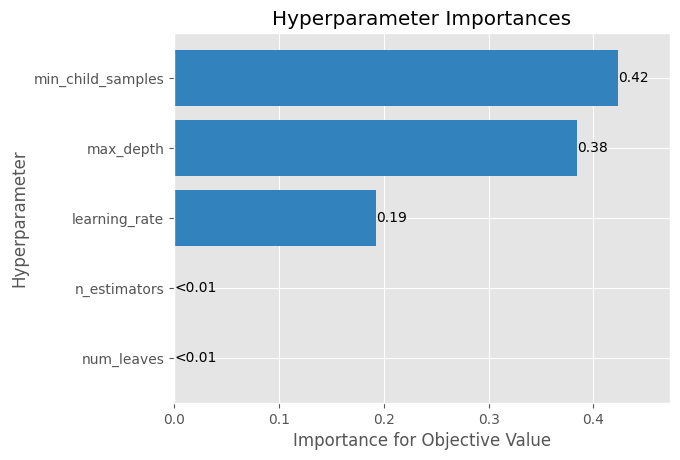

In [111]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study); #визуализируем важность гиперпараметров

In [113]:
# воспользуемся найденными гиперпараметрами и ещё раз обучим модель
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

finish_test_preds =[]
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
    model = lg.LGBMRegressor(objective='regression', **study.best_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmsle', early_stopping_rounds=100, verbose=-1)
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    
    print(f'id = {idx}', cv_predicts[idx], '\n')
    
print(np.mean(cv_predicts))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 0.202548
id = 0 0.45005328032319625 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's l2: 0.201322
id = 1 0.44868877039831306 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's l2: 0.202177
id = 2 0.4496411116380108 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 0.198263
id = 3 0.4452671660576098 

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 0.202162
id = 4 0.44962390483867815 

0.4486548466511616


In [114]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred_exp = np.exp(test_pred.data) - 1

y_test_exp = np.exp(y_test.values) - 1

In [115]:
print(f'OOF score: {np.mean(cv_predicts)}')
print(f'HOLDOUT score: {rmsle(y_test_exp, test_pred_exp)}')

OOF score: 0.4486548466511616
HOLDOUT score: 0.4453208533182683


In [116]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test, y_test, n_repeats=5)

In [117]:
r

{'importances_mean': array([3.32465571e-03, 4.63340091e-03, 1.89577229e-05, 1.47966691e-03,
        1.74677406e-03, 7.66969803e-04, 1.12432279e-03, 1.27393072e-04,
        2.12698401e-03, 4.22991003e-03, 1.62266407e-03, 3.94794183e-02,
        1.09985680e-01, 3.19776223e-03, 4.46107908e-04, 1.97617147e-03,
        4.59133981e-05, 1.30614763e+00]),
 'importances_std': array([1.41119469e-04, 1.97003741e-04, 5.44427527e-06, 5.16417177e-05,
        4.95241811e-05, 2.59838459e-05, 3.84223548e-05, 2.48414098e-05,
        3.15780905e-05, 7.77662345e-05, 1.22399131e-04, 2.19595124e-04,
        5.33667828e-04, 5.90598492e-05, 2.46719815e-05, 4.44771273e-05,
        8.20554830e-06, 1.94469265e-03]),
 'importances': array([[3.17332333e-03, 3.44703851e-03, 3.14169708e-03, 3.48431305e-03,
         3.37690660e-03],
        [4.61475295e-03, 4.75063595e-03, 4.42605666e-03, 4.43179621e-03,
         4.94376276e-03],
        [2.28255127e-05, 1.56033067e-05, 2.33547752e-05, 2.32329836e-05,
         9.7720

In [118]:
perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()), index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

In [119]:
perm_df

,Score,Features
17,1.30615,log_distance_geo
12,0.10999,pickup_hour
11,0.03948,pickup_dayofweek
1,0.00463,passenger_count
9,0.00423,pickup_month
0,0.00332,vendor_id
13,0.00320,pickup_minute
8,0.00213,snow depth
15,0.00198,pickup_holiday
4,0.00175,minimum temperature


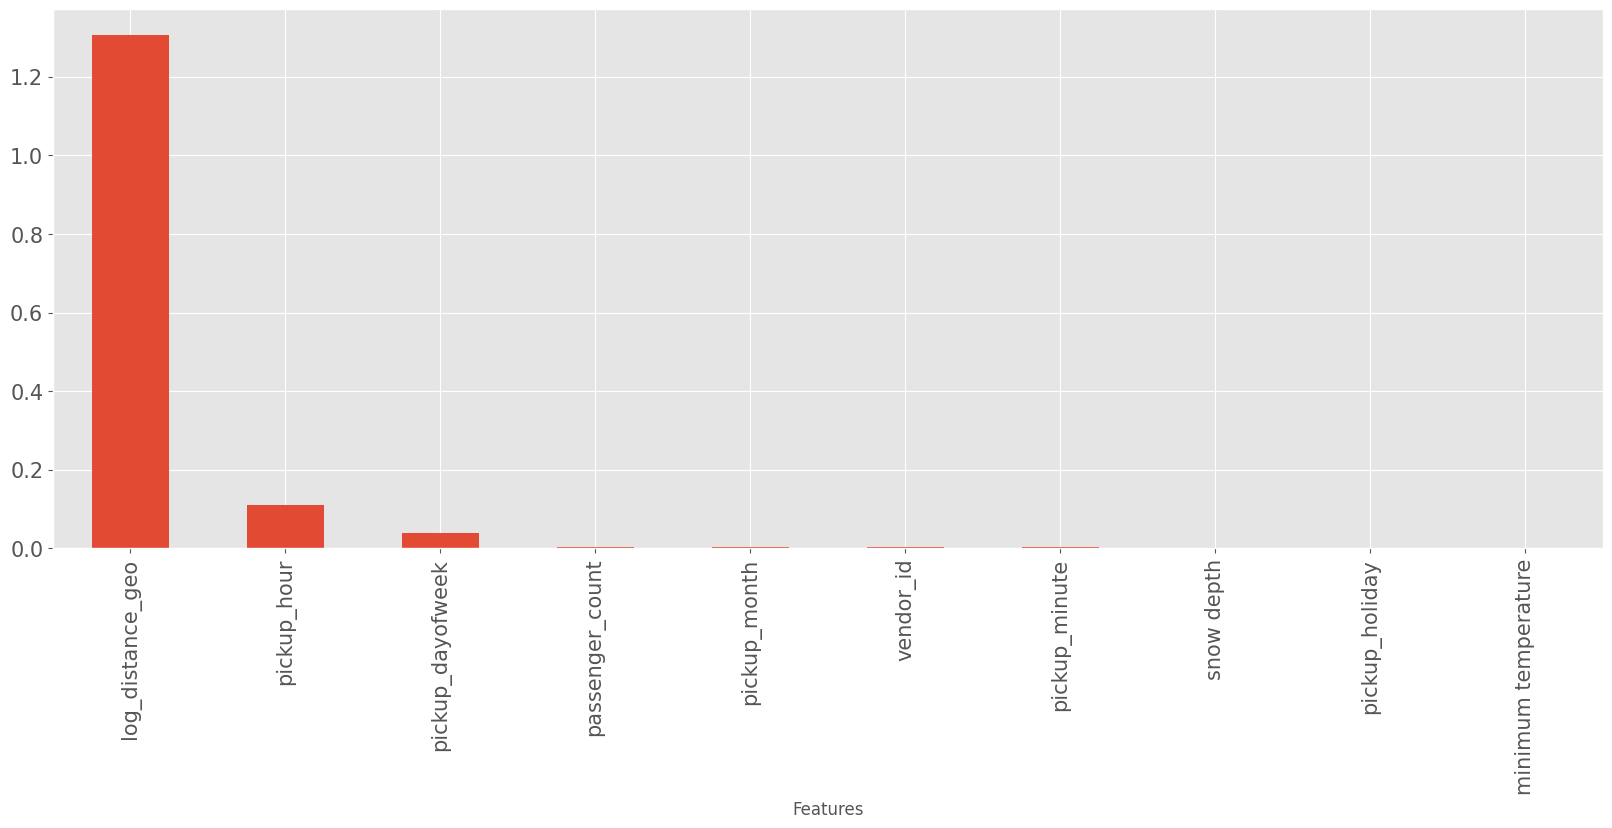

In [126]:
perm_df[:10].set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()